**Overview**


*   The data used here is what we scraped from the "snscrape.ipynb" file
*   Scraping was done on local machine as Google Colab uses Python Version 3.6 as of the time this was published; snscrape only works with Pyhon 3.8 and above.



**Importing Libraries & Modules**

In [25]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
import numpy as np
import re
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)
from plotly import graph_objs as go
from google.colab import drive
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
#Mount the google drive folder

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Load the dataset

nairobi_df = pd.read_csv('/content/gdrive/My Drive/Coronavirus_Tweets/nairobi_county.csv')

#Preview the first four rows of the dataset

nairobi_df.head()

,Unnamed: 0,Unnamed: 0.1,Datetime,Text,retweets,likes
0,0,0,2020-06-06 19:28:03+00:00,Mmetukosea sana! \n\nSasa ningeenda hadi pahal...,0,2
1,1,1,2020-06-06 13:25:27+00:00,CAN'T WAIT 🥰🥰 #6thjune #BlackLivesMatter #Curf...,1,10
2,2,2,2020-06-06 13:24:27+00:00,Wakenya hawachoki na meme za Uhuru😂😂 #UhuruKen...,1,4
3,3,3,2020-06-06 13:03:01+00:00,Fellow Kenyans #uhuruspeaks #UhuruAddress http...,0,1
4,4,4,2020-06-06 13:02:49+00:00,#UhuruKenyatta Cessation of movement in Nairob...,0,2


In [4]:
#Preview the last four rows of the dataset

nairobi_df.tail()

,Unnamed: 0,Unnamed: 0.1,Datetime,Text,retweets,likes
8179,37,37,2020-05-29 06:20:25+00:00,President Uhuru Kenyatta made it clear that's ...,0,2
8180,38,38,2020-05-29 06:03:22+00:00,#Uhurustoughchoices Mlisema huyu Ni mtoto wa N...,0,0
8181,39,39,2020-05-29 05:19:20+00:00,Among other tough choices Uhuru must make is g...,3,4
8182,40,40,2020-05-27 18:59:53+00:00,Pandemic. Perforated pockets. Plunging economy...,1,6
8183,41,41,2020-05-27 18:54:16+00:00,Pandemic. Perforated pockets. Plunging economy...,26,35


### Shape of the data

In [5]:
#number of rows and columns of the data

nairobi_df.shape

(8184, 6)

In [6]:
#Checking the data types of our data

""" This is crucial for modeling tasks. e.g when solving a regression problem, we only deal with numerical data types and not categorical. """

nairobi_df.dtypes

Unnamed: 0       int64
Unnamed: 0.1     int64
Datetime        object
Text            object
retweets         int64
likes            int64
dtype: object

**Cleaning the Data**

### Dealing with missing values

In [7]:
#Checking for missing values

""" If there are missing values in the columns, we either fill or drop them from the respective columns with too many missing values that are not of significance to the modeling task.

For this case, there are no missing values to handle."""

nairobi_df.isnull().sum()

Unnamed: 0      0
Unnamed: 0.1    0
Datetime        0
Text            0
retweets        0
likes           0
dtype: int64

In [8]:
#Checking for duplicates
print(nairobi_df.duplicated().any())

True


In [9]:
#Dropping Duplicates

nairobi_df.drop_duplicates(keep=False, inplace=True)

#Confirming there are no duplicates

print(nairobi_df.duplicated().any())
print(nairobi_df.shape)

False
(4214, 6)


### Dealing with Outliers

##### We check for outliers because often times, they result into an impbalanced data for modeling. i.e too many outliers bring about a high variance to our data. High variance causes overfitting to our model.

##### A Z score is used since our dataset consists of more than 30 rows.

In [10]:
#Dealing with outliers
#
#Import stats from scipy library

from scipy import stats
num = ['retweets']
for i, col in enumerate(num):
    z = np.abs(stats.zscore(nairobi_df[col]))
print(z)

[0.14138055 0.0583916  0.0583916  ... 0.10758628 0.0583916  2.016332  ]


In [11]:
#Confirming that our outliers have been dropped from the data set

nairobi_df2 = nairobi_df[( z < 2 )]

print(f"Previous dataframe size : {nairobi_df.shape[0]}" )
print(f"New dataframe size : {nairobi_df2.shape[0]}" )

Previous dataframe size : 4214
New dataframe size : 4173


In [12]:
nairobi_df2.describe()

,Unnamed: 0,Unnamed: 0.1,retweets,likes
count,4173.000000,4173.000000,4173.000000,4173.000000
mean,1358.447160,1358.447160,0.938414,3.865564
std,1011.783419,1011.783419,2.363796,11.781585
min,0.000000,0.000000,0.000000,0.000000
25%,444.000000,444.000000,0.000000,0.000000
50%,1195.000000,1195.000000,0.000000,1.000000
75%,2241.000000,2241.000000,1.000000,3.000000
max,3298.000000,3298.000000,25.000000,202.000000


**Cleaning the Text**

In [13]:
#Map the lowering function to all column names

nairobi_df2.columns = map(str.lower, nairobi_df2.columns)

#Print the column names

for col in nairobi_df2:
    print(col)

unnamed: 0
unnamed: 0.1
datetime
text
retweets
likes


In [14]:
#Removing Whitespace from both columns and rows and converting case to lower case
#
#Converting the text column to string dtype after getting an attribute error
"""nairobi_df2['text'] = nairobi_df2['text'].astype(str)

nairobi_df2.columns = nairobi_df2.str.strip().str.replace(",").str.lower()

cat = nairobi_df2['text']

for i, c in enumerate(cat):
    nairobi_df2[cat] = nairobi_df2[c].str.strip().str.replace(",").str.lower()"""

#Make text lowercase, remove text in square brackets, remove links, remove punctuation and remove words containing numbers
import re
import string

def clean_text(text):
    text = str(text).lower()
    text = re.sub("\[.*?\]", '', text)
    text = re.sub("https?://\S+|www\.S+", '', text)
    text = re.sub("<.*?>+", '', text)
    text = re.sub("[%s]" % re.escape(string.punctuation) , '', text)
    text = re.sub("\n", '', text)
    text = re.sub("\w*\d\w*", '', text)
    return text

In [15]:
#Using a lambda function to clean the text column

nairobi_df2['text'] = nairobi_df2['text'].apply(lambda x:clean_text(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
#Preview the dataset to see changes

nairobi_df2.tail()

,unnamed: 0,unnamed: 0.1,datetime,text,retweets,likes
8178,36,36,2020-05-29 06:34:32+00:00,theres nothing like making a tough choice when...,0,0
8179,37,37,2020-05-29 06:20:25+00:00,president uhuru kenyatta made it clear thats t...,0,2
8180,38,38,2020-05-29 06:03:22+00:00,uhurustoughchoices mlisema huyu ni mtoto wa na...,0,0
8181,39,39,2020-05-29 05:19:20+00:00,among other tough choices uhuru must make is g...,3,4
8182,40,40,2020-05-27 18:59:53+00:00,pandemic perforated pockets plunging economy p...,1,6


In [18]:
#Removing Stopwords

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop = stopwords.words('english')

nairobi_df2['text_without_stopwords'] = nairobi_df2['text'].apply(lambda x: ' '.join(word for word in str(x).split() if word not in stop))#this method gives back a list of words

nairobi_df2.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,unnamed: 0,unnamed: 0.1,datetime,text,retweets,likes,text_without_stopwords
0,0,0,2020-06-06 19:28:03+00:00,mmetukosea sana sasa ningeenda hadi pahali gar...,0,2,mmetukosea sana sasa ningeenda hadi pahali gar...
1,1,1,2020-06-06 13:25:27+00:00,cant wait 🥰🥰 blacklivesmatter curfewinkenya w...,1,10,cant wait 🥰🥰 blacklivesmatter curfewinkenya wa...
2,2,2,2020-06-06 13:24:27+00:00,wakenya hawachoki na meme za uhuru😂😂 uhurukeny...,1,4,wakenya hawachoki na meme za uhuru😂😂 uhurukeny...
3,3,3,2020-06-06 13:03:01+00:00,fellow kenyans uhuruspeaks uhuruaddress,0,1,fellow kenyans uhuruspeaks uhuruaddress
4,4,4,2020-06-06 13:02:49+00:00,uhurukenyatta cessation of movement in nairobi...,0,2,uhurukenyatta cessation movement nairobi momba...


In [ ]:
#Check for the maximum and minimum dates in the data

print(f" Data Available since {nairobi_df2.datetime.min()}")
print(f" Data Available upto {nairobi_df2.datetime.max()}")

**Visualizations**

### Common Words

In [ ]:
#Checking for the most common words

from collections import Counter
nairobi_df2['text_without_stopwords'] = nairobi_df2['text_without_stopwords'].apply(lambda x:str(x).split())
top = Counter([item for sublist in nairobi_df2['text_without_stopwords'] for item in sublist])
tweets = pd.DataFrame(top.most_common(51))
tweets.columns = ['common words', 'count']
tweets.style.background_gradient(cmap = 'Blues')

### Wordcloud

In [31]:
def plot_wordcloud(text, mask=None, max_words=500, max_font_size=100, figure_size=(14.0,6.0), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'sasa', "wa", 'wa', 'sana', 'hadi', 'na'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
d = '/content/gdrive/My Drive/Coronavirus_Tweets/'

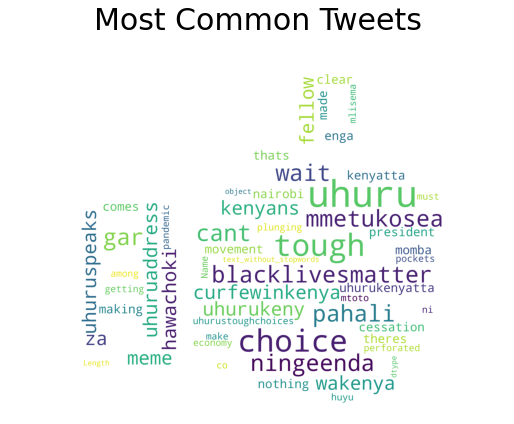

In [32]:
pos_mask = np.array(Image.open(d+ 'upvote.png'))
plot_wordcloud(nairobi_df2.text_without_stopwords,mask=pos_mask,color='white',max_font_size=300,title_size=30,title="Most Common Tweets")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



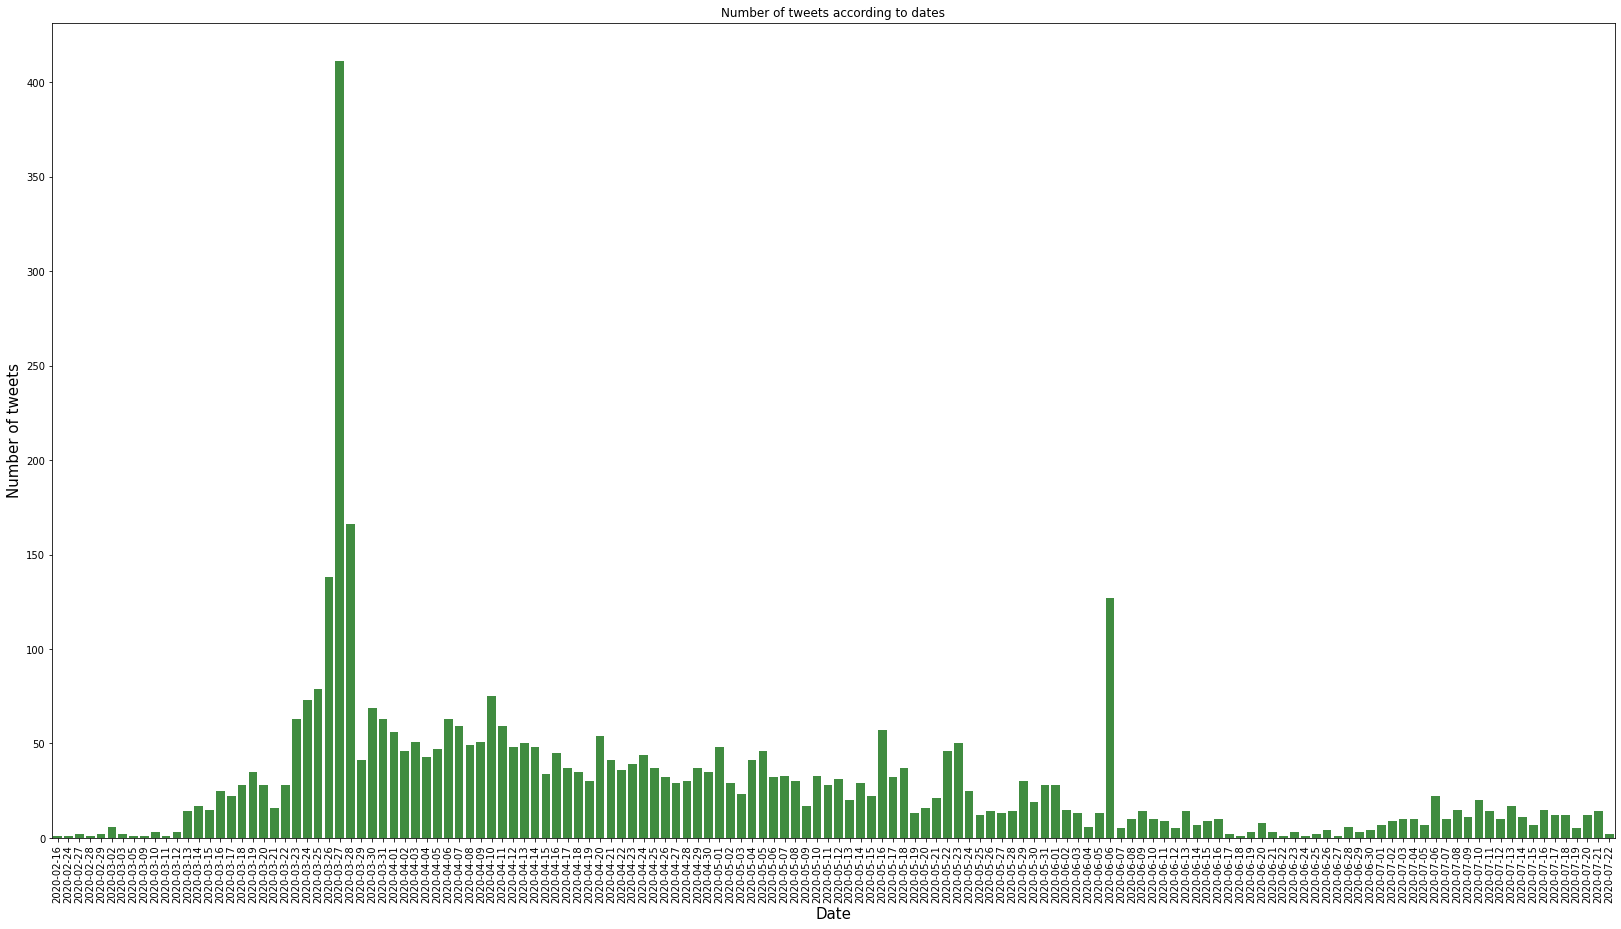

In [33]:
#The number of tweets according to dates

nairobi_df2['datetime'] =  pd.to_datetime(nairobi_df2['datetime'])
cnt_srs =nairobi_df2['datetime'].dt.date.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(28,15))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='green')
plt.xticks(rotation='vertical')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Number of tweets', fontsize=15)
plt.title("Number of tweets according to dates")
plt.show()

# <center>**Bag of Words**</center>